In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import splu, spsolve

from src.array import Array
from src.matrix_charge import Matrix as Matrix_charge
from src.matrix_discharge import Matrix as Matrix_discharge
from src.equation import Equation
from src.failure import Failure

In [9]:
length = 10
width = 1.0
seed = 0
val_cap = 0.01
time_step = 0.01
cond_ext = 1.0
mode_analysis = True
save_volts_profile = True

In [10]:
array = Array(length=length, mode_analysis=mode_analysis)
matrix_ch = Matrix_charge(matrix_init=None, array=array, val_cap=val_cap, time_step=time_step)
matrix_dch = Matrix_discharge(matrix_init=None, array=array, cond_ext=cond_ext, val_cap=val_cap, time_step=time_step)
equation = Equation(array=array, matrix_ch=matrix_ch, matrix_dch=matrix_dch, save_volts_profile=save_volts_profile)
failure = Failure(array=array, matrix_ch=matrix_ch, matrix_dch=matrix_dch, equation=equation, width=width, seed=seed, save_volts_profile=save_volts_profile)

In [ ]:
solve_r = equation.solve_r_amd

def run_charge_cycle_first(duration_cycle: int) -> bool:
    solve = equation.solve_true_init_ch
    break_edge = failure.break_edge_true_init_ch()
    solve(); break_edge()  # t=0 fresh start

    solve = equation.solve_ch
    break_edge = failure.break_edge_ch
    for _ in range(duration_cycle - 1):
        if not solve_r(): # island shield
            return False
        solve(); break_edge()
    return True

def run_charge_cycle_from_dch(duration_cycle: int) -> bool:
    if not solve_r(): return False # island shield

    solve = equation.solve_init_ch
    break_edge = failure.break_edge_ch
    solve(); break_edge()  # t=0 after D→C (caps nonzero)

    solve = equation.solve_ch
    break_edge = failure.break_edge_ch
    for _ in range(duration_cycle - 1):
        if not solve_r(): # island shield
            return False
        solve(); break_edge()
    return True

def run_discharge_cycle(duration_cycle: int) -> bool:
    if not solve_r(): return False # island shield

    solve = equation.solve_init_dch
    break_edge = failure.break_edge_dch
    solve(); break_edge()  # t=0 for C→D

    solve = equation.solve_dch
    break_edge = failure.break_edge_dch
    for _ in range(duration_cycle - 1):
        if not solve_r(): # island shield
            return False
        solve(); break_edge()
    return True


In [12]:
duration_charge = array.length // 2
duration_discharge = array.length // 2

if run_charge_cycle_first(duration_charge):
    while run_discharge_cycle(duration_discharge) and run_charge_cycle_from_dch(duration_charge):
        pass


In [ ]:

FIX THIS 



unsigned: bool = True 
profile: np.ndarray = np.array(failure.volts_cap_profile, dtype=np.float64).transpose() # [edge, time] 
if unsigned: np.abs(profile, out=profile) 
idxs_edge_broken: np.ndarray = np.array(failure.idxs_edge_broken, dtype=np.int32) 
num_edge, num_time = profile.shape 

for idx_time, idx_edge_broken in zip(failure.idxs_time_edge_broken, idxs_edge_broken): 
    profile[idx_edge_broken, (idx_time + 1):] = np.nan

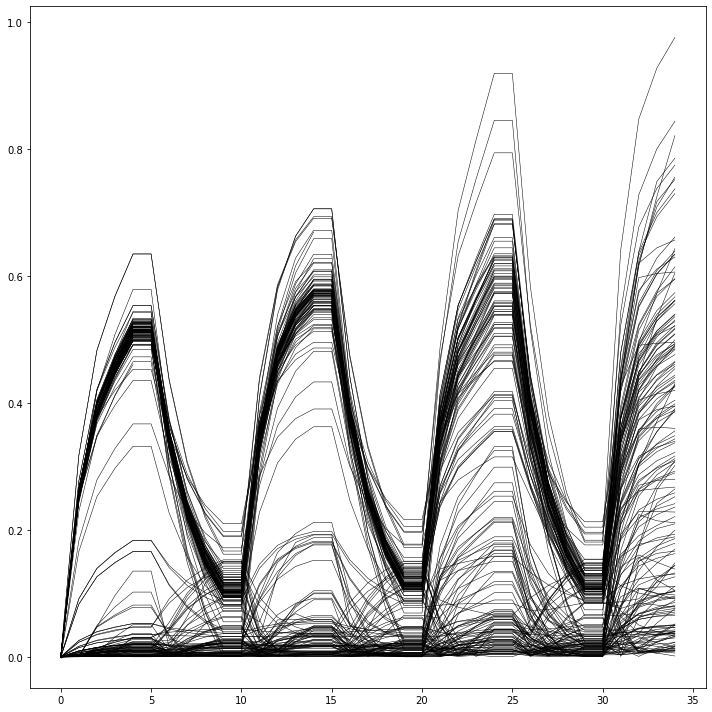

In [ ]:
size_obj = 0.5
unsigned = True

profile: np.ndarray = np.array(failure.volts_cap_profile, dtype=np.float64).copy().transpose() # [edge, time]
idxs_edge_broken = failure.idxs_edge_broken
if unsigned: np.abs(profile, out=profile)
num_edge, num_time = profile.shape

for idx_time, idx_edge_broken in enumerate(idxs_edge_broken):
    # if idx_edge_broken is not None:
    profile[idx_edge_broken, (idx_time + 1):] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

#
ax.scatter(0, profile[idxs_edge_broken[0], 0], c="black", s=size_obj, zorder=num_edge)
for idx_edge, votls_per_edge in enumerate(profile):
    if idx_edge in idxs_edge_broken:
        ax.plot(range(num_time), votls_per_edge, c="black", lw=size_obj, zorder=num_edge)
    else:
        ax.plot(range(num_time), votls_per_edge, c="black", lw=size_obj)

#
# ax.set_xlim(20, 40)
# ax.set_ylim(-0.1, 0.25)

plt.tight_layout()
plt.show()

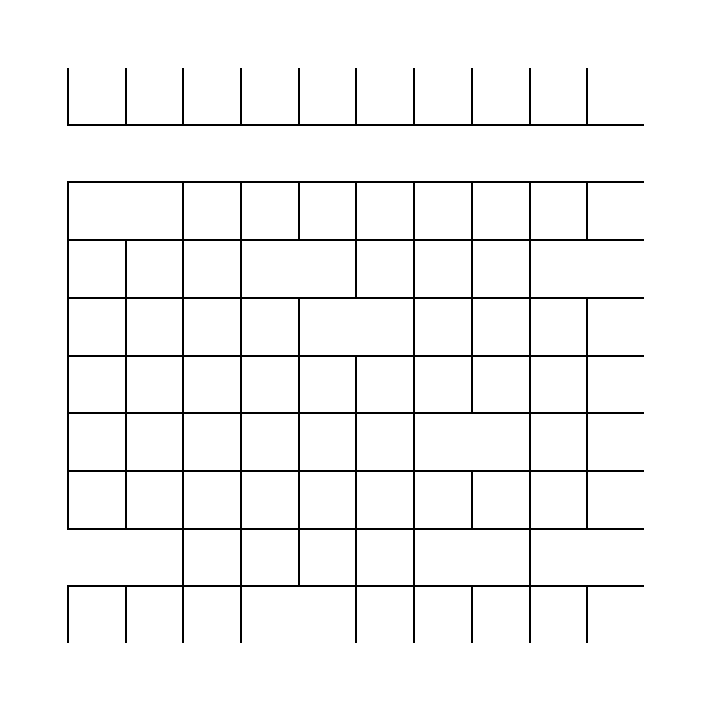

In [ ]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from resistor_capacitor.breakdown import breakdown
from analysis.rcc_src_tbc.draw import Draw

draw = Draw(array, matrix_ch, equation, failure)
draw.graph_initialize(
    figsize=(10, 10), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(failure.idxs_edge_broken, 0)
# draw.graph_breakdown_images()
# draw.graph_breakdown_video()

In [8]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# # make a “discharge-only” line:
# # charge steps = NaN; discharge steps = last finite V_ext from the preceding charge cycle
# v = np.asarray(failure.volts_ext, dtype=np.float64)
# valid = np.isfinite(v)                       # True on charge steps (your log), False on discharge
# idx = np.arange(v.size)
# last_idx = np.maximum.accumulate(np.where(valid, idx, 0))
# ffill = v[last_idx]
# ffill[~valid.cumsum().astype(bool)] = np.nan # before first finite, keep NaN
# volt_ext_dch = np.where(valid, np.nan, ffill)

# # then plot it:
# # ax.plot(volt_ext_dch, lw=2)


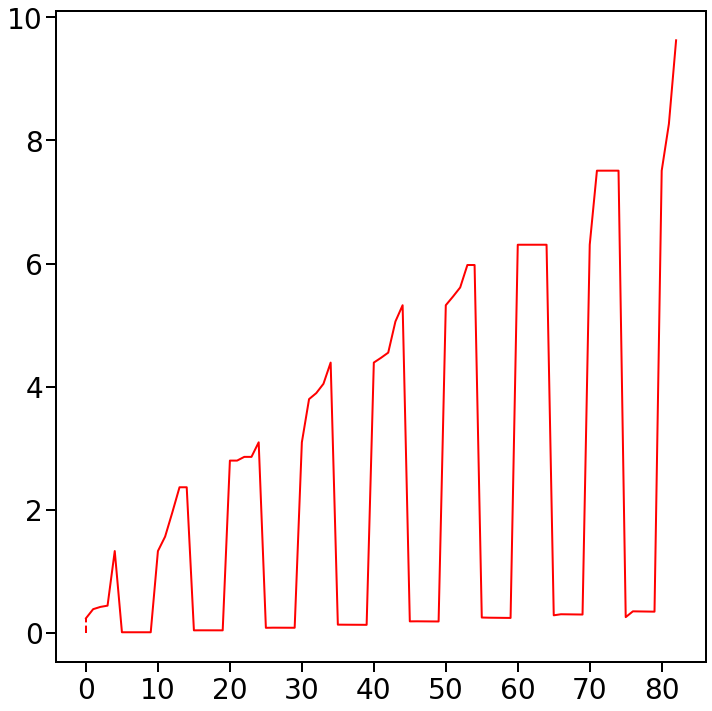

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

ax.plot(failure.volts_ext, c="red", lw=2)

v = np.asarray(failure.volts_ext, dtype=np.float64)
is_ch = np.isfinite(v)
prev_is_ch = np.pad(is_ch[:-1], (1, 0), constant_values=False)
starts = np.nonzero(is_ch & ~prev_is_ch)[0]  # x-positions to draw vlines
for x in starts:
    ax.vlines(x, ymin=0.0, ymax=v[x], linestyles="--", colors="red", lw=2.0, alpha=1)




ax.tick_params(labelsize=28, width=2, length=10)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)


ax.set_xticks(np.arange(0, 90, 10))
plt.tight_layout()
plt.show()

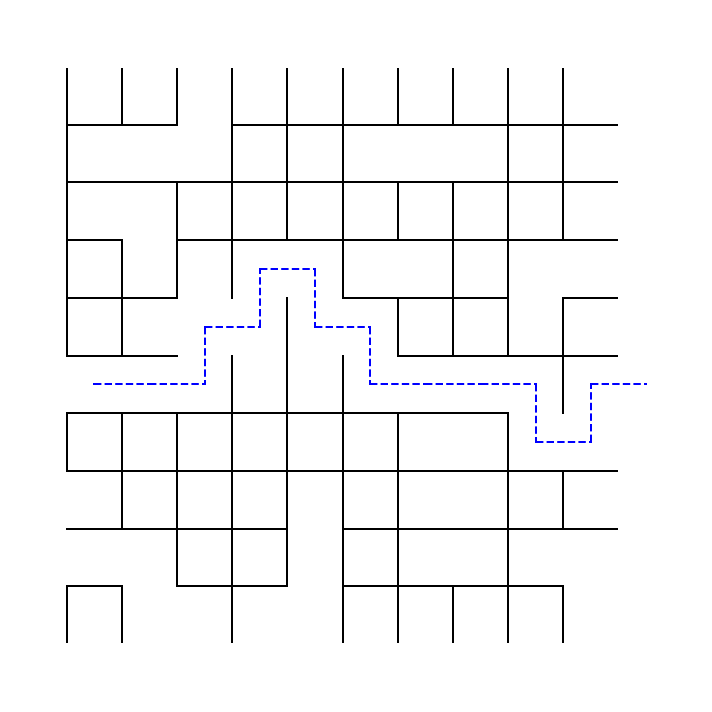

In [ ]:
#
length, length_minus_one, length_plus_one = array.length, array.length - 1, array.length + 1
num_face = array.length ** 2
faces = list(range(num_face))

#
faces_to_nodes, faces_to_edges = [None] * num_face, [None] * num_face

for face in faces:
    nodes = [face, face + length]

    if (face + 1) % array.length == 0: # face which contains 2 "periodic" nodes
        nodes.append(face + 1)
        nodes.append(face - length_minus_one)
    else:
        nodes.append(face + length_plus_one)
        nodes.append(face + 1)
    faces_to_nodes[face] = nodes
    
    faces_to_edges[face] = [
        (nodes[0], nodes[1]), 
        (nodes[1], nodes[2]) if nodes[1] < nodes[2] else (nodes[2], nodes[1]) ,
        (nodes[3], nodes[2]), 
        (nodes[0], nodes[3]) if nodes[0] < nodes[3] else (nodes[0], nodes[3]),
    ]

#
dict_edge_to_idx_edge = {edge: idx_edge for idx_edge, edge in enumerate(array.edges)}
dict_edge_to_idx_edge

#
faces_to_idxs_edge = [None] * num_face
for face, edges in enumerate(faces_to_edges):
    idxs_edge = []
    for edge in edges:
        try:
            idxs_edge.append(dict_edge_to_idx_edge[edge])
        except:
            idxs_edge.append(None)
        
        faces_to_idxs_edge[face] = idxs_edge

#
idxs_edge_to_edges_dual = [None] * array.num_edge
idxs_edge_to_edges_dual_pseudo = [None] * array.num_edge
for idx_edge, edge in enumerate(array.edges):
    idx_node1, idx_node2 = edge # idx_node1 < idx_node2

    # vertical
    if idx_node2 == idx_node1 + length:

        if idx_node1 % length == 0: # EDGE_DUAL AFFECTED BY PBC PERIODICITY
            idx_face1 = idx_node1
            idx_face2 = idx_node2 - 1

            idx_face1_pseudo = - idx_node1 // length - 1
        else:
            idx_face1 = idx_node1 - 1
            idx_face2 = idx_node1

            idx_face1_pseudo = idx_node1 - 1
        
    # horizontal
    else:
        if idx_node1 % length == 0 and idx_node2 % length == length_minus_one: # EDGE_DUAL AFFECTED BY PBC PERIODICITY
            idx_face1 = idx_node1 - 1
            idx_face2 = idx_node2

            idx_face1_pseudo = idx_node1 - 1
        else:
            idx_face1 = idx_node1 - length
            idx_face2 = idx_node1

            idx_face1_pseudo = idx_node1 - length

    idxs_edge_to_edges_dual[idx_edge] = (idx_face1, idx_face2) # must be sorted tuple int pairs
    idxs_edge_to_edges_dual_pseudo[idx_edge] = (idx_face1_pseudo, idx_face2)

# sanity check
(
    all([xd == (xd[0], xd[1]) if xd[0] < xd[1] else (xd[1], xd[0]) for xd in idxs_edge_to_edges_dual]),
    all([xd == (xd[0], xd[1]) if xd[0] < xd[1] else (xd[1], xd[0]) for xd in idxs_edge_to_edges_dual_pseudo])
)

colors_edge = draw.colors_edge.astype(np.float16)
colors_edge[failure.idxs_edge_broken] = np.ones(3, dtype=np.int8)
colors_edge = np.vstack([colors_edge[draw.idxs_edge_pbc][::-1], np.delete(colors_edge, draw.idxs_edge_pbc, axis=0)])

faces_pos_x, faces_pos_y = np.meshgrid(np.arange(length) + 0.5, np.arange(length, 0, -1) - 0.5)
faces_pos_x, faces_pos_y = faces_pos_x.reshape(-1), faces_pos_y.reshape(-1)
faces_pos = {idx_face: (float(face_pos_x), float(face_pos_y)) for idx_face, (face_pos_x, face_pos_y) in enumerate(zip(faces_pos_x, faces_pos_y))}

faces_pos_pseudo = {(-length + i): (length + 0.5, i + 0.5)  for i in range(length)} | faces_pos

edges_dual = np.array(idxs_edge_to_edges_dual)[failure.idxs_edge_broken].tolist() # NOT FOR PLOTTING
graph_dual = nx.Graph()
graph_dual.add_edges_from(edges_dual)

edges_dual_pseudo = np.array(idxs_edge_to_edges_dual_pseudo)[failure.idxs_edge_broken].tolist() # FOR 2D PLOTTING PBC PERIODICITY COVERED
graph_dual_pseudo = nx.Graph()
graph_dual_pseudo.add_edges_from(edges_dual_pseudo)

# RC
all_subgraph_dual = []
all_subgraph_dual_pseudo = []
all_subgraph_dual_pseudo_pos = []
all_cycles = nx.cycle_basis(graph_dual)
for cycle in all_cycles:
    cycle = [(cycle[idx], cycle[idx + 1]) for idx in range(len(cycle) - 1)] + [(cycle[0], cycle[-1])] ######## 

    cycle = [(c1, c2) if c1 < c2 else (c2, c1) for c1, c2 in cycle]
    subgraph_dual = nx.Graph()
    subgraph_dual.add_edges_from(cycle)
    all_subgraph_dual.append(subgraph_dual)

    cycle_pseudo = [(-(idx_face2 + 1) // length, idx_face2) if (idx_face2 - idx_face1 == length_minus_one) else (idx_face1, idx_face2) for idx_face1, idx_face2 in cycle]
    subgraph_dual_pseudo = nx.Graph()
    subgraph_dual_pseudo.add_edges_from(cycle_pseudo)

    subgraph_dual_pseudo_pos = {}
    for key, val in faces_pos_pseudo.items():
        if key in subgraph_dual_pseudo.nodes:
            subgraph_dual_pseudo_pos[key] = val

    all_subgraph_dual_pseudo.append(subgraph_dual_pseudo)
    all_subgraph_dual_pseudo_pos.append(subgraph_dual_pseudo_pos)


fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=draw.dpi)
nx.draw(
    draw.graph, ax=ax, 
    pos=draw.pos,
    node_shape="s", node_color=draw.colors_node, edgecolors="none", edge_color=colors_edge, 
    node_size=draw.size_edge ** 2, width=draw.size_edge,
    # with_labels=True, font_color="black", font_size=10,
)

nx.draw(
    graph_dual_pseudo, ax=ax,
    pos=faces_pos_pseudo,
    node_shape="s", node_color="none", edgecolors="none", edge_color="none", 
    node_size=draw.size_edge ** 2, width=draw.size_edge,
    # with_labels=True, font_color="red", font_size=10,
)

# RC
colors = plt.colormaps["jet_r"](np.linspace(0.25, 1.0, len(all_subgraph_dual_pseudo)))
for subgraph_dual_pseudo, subgraph_dual_pseudo_pos, color in zip(all_subgraph_dual_pseudo, all_subgraph_dual_pseudo_pos, colors):
    nx.draw(
        subgraph_dual_pseudo, ax=ax,
        pos=subgraph_dual_pseudo_pos,
        node_shape="s", node_color="blue", edgecolors="none", edge_color="blue", # [color],
        node_size=draw.size_edge ** 2, width=draw.size_edge, style="--"
    )
plt.tight_layout()
plt.show()

In [ ]:
graph = nx.Graph()
edges = array.edges.copy()
edges.extend([(idx_node, idx_node + 1) for idx_node in range(length - 1)] + [(0, length - 1)])
edges.extend([(idx_node, idx_node + 1) for idx_node in range(length ** 2, length ** 2 + length - 1)] + [(length ** 2, length ** 2 + length - 1)])

for idx_edge_broken in sorted(failure.idxs_edge_broken, reverse=True):
    edges.pop(idx_edge_broken)
graph.add_edges_from(edges)

nx.number_connected_components(graph)

2

In [ ]:
asd

NameError: name 'asd' is not defined

In [ ]:
def count_broken_per_cycle(failure, duration_charge: int, duration_discharge: int):
    t = np.asarray(failure.idxs_time_edge_broken, dtype=np.int64)
    if t.size == 0:
        return np.array([], int), np.array([], int)
    period = duration_charge + duration_discharge
    cyc = t // period
    is_ch = (t % period) < duration_charge
    ncyc = int(cyc.max()) + 1
    ch = np.zeros(ncyc, dtype=int)
    dch = np.zeros(ncyc, dtype=int)
    for c, f in zip(cyc, is_ch):
        (ch if f else dch)[c] += 1
    return ch, dch
count_broken_per_cycle(failure, duration_charge, duration_discharge)

(array([5, 5, 5, 5, 5, 5, 5, 5, 3]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
len(failure.idxs_edge_broken)

43

In [ ]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from resistor_capacitor.breakdown import breakdown
from analysis.rcc_src_tbc.draw import Draw


In [ ]:
np.array_equal(list(set(failure.idxs_edge_broken)), list(set(breakdown(length, width, seed, val_cap, time_step)[-1].idxs_edge_broken)))

True

In [ ]:
len(breakdown(length, width, seed, val_cap, time_step)[-1].idxs_edge_broken), len(failure.idxs_edge_broken)

(43, 43)

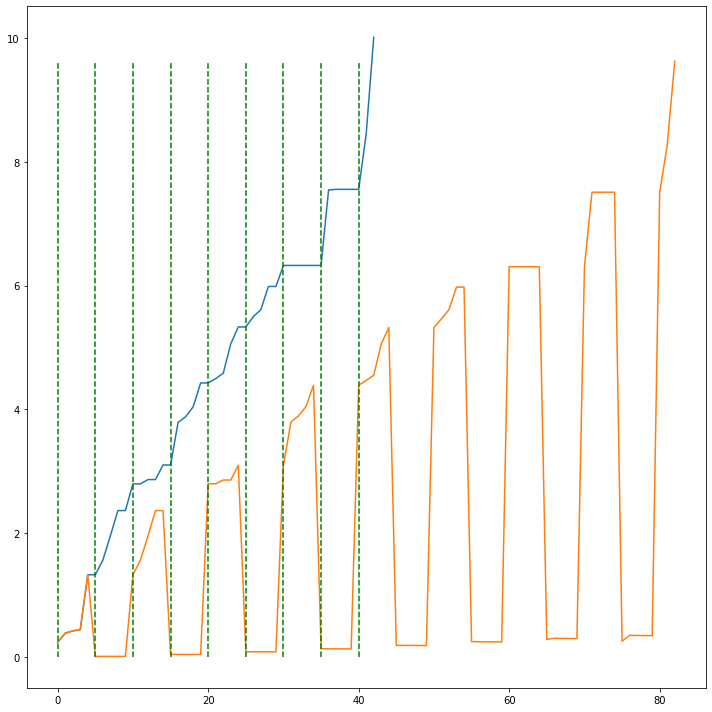

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

ax.plot(breakdown(length, width, seed, val_cap, time_step)[-1].volts_ext)
ax.plot(np.array(failure.volts_ext)[~np.isnan(failure.volts_ext)])
# ax.plot(failure.volts_ext)

ax.vlines(np.arange(0, len(failure.idxs_edge_broken), duration_charge), 0, np.nanmax(failure.volts_ext), colors="green", linestyles="--")


plt.tight_layout()
plt.show()

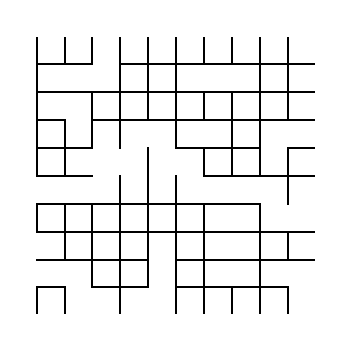

In [ ]:
draw = Draw(array, matrix_ch, equation, failure)
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(failure.idxs_edge_broken, 0)

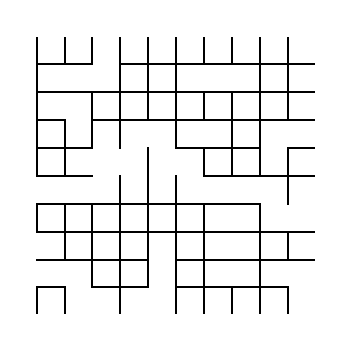

In [ ]:
draw = Draw(*breakdown(length, width, seed, val_cap, time_step))
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(failure.idxs_edge_broken, 0)

---

In [ ]:
# # breakdown simulation
# # 1st bond breaking [t=0]
# solve = equation.solve_init
# break_edge = failure.break_edge_init
# solve()
# break_edge()

# # 2nd ~ (length)th bond breaking [t=1 ~ t=(length-1)]
# solve = equation.solve
# solve_r = equation.solve_r_mmd
# break_edge = failure.break_edge
# for _ in range(array.length - 1):
#     solve_r()
#     solve()
#     break_edge()

# # (length+1)th ~ (macroscopic failure) bond breaking [t=(length) ~ (total number of broken bonds-1)]
# solve_r = equation.solve_r_amd
# while solve_r():
#     solve()
#     break_edge()